# PO 280 - Otimização Multi-Critério 

# Rafael Andreolli Prochnow RA176059

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import *

O problema apresentado no trabalho consistem na implementação dos métodos clássicos estudados na disciplina para encontrar quais os ativos (ações) mais adequados para investir. Métodos da Soma Ponderada, ԑ-restrito, Critério Global e Programação por Metas. 
Os dados utilizados na elaboração do trabalho foram disponibilizados pela professora. 

Os dados são compostos por 49 ativos no período 1 de Abril de 2019 até 31 de Março de 2020. Foi pedido que acrescentasse uma ou mais restrições ao problema, sendo assim, de forma aleatória, a soma dos os ativos 2, 9, 15, 21 e 35 deve corresponder a 30% do investimento. 

# Processo de leitura e processamento dos dados 

In [2]:
# ler as quantidades: ATIVOS e PERIODOS e a tabela de precos
def leitura(arquivo):
    # abre o arquivo para leitura, na aba Valores
    ARQ = pd.read_excel(arquivo, sheet_name='Valores')
    ATIVOS = ARQ.at[0,'Qtde']
    PERIODOS = ARQ.at[1,'Qtde']
    
    # abre o arquivo para leitura, na aba Precos
    ARQ = pd.read_excel(arquivo, sheet_name='Precos')
    Preco = []
    nomesAcoes = []  # apresentação final
    for i in range(ATIVOS):  # coluna
        nomecoluna = "Acao"+str(i+1)
        PrecoI = []  
        for t in range(PERIODOS):  # linha
            PrecoIK = ARQ.at[t, nomecoluna]   
            PrecoI.append(PrecoIK)   
        Preco.append(PrecoI)   
        
    return ATIVOS, PERIODOS, Preco

# calcular retATIVOS (para f1) e covATIVOS (para f2)
def preProcessamento(ATIVOS, PERIODOS, Preco):
    # criar a matriz r 
    r = []
    for i in range (ATIVOS):        # para cada linha
        crialinha = []        
        for t in range (PERIODOS):  # para cada coluna
            crialinha.append(0)     # preencho a linha com 0s em todas as colunas
        r.append(crialinha)
        
    # calculo do r[i][t]    
    for i in range (ATIVOS):
        for t in range (1, PERIODOS): 
            r[i][t-1] = (Preco[i][t]/Preco[i][t-1]) - 1
  
    # criar o vetor retATIVOS
    retATIVOS = []
    for i in range (ATIVOS):
        retATIVOS.append(0)  #  retATIVOS[i] = 0
        
    # calculo do retATIVOS[i]
    for i in range (ATIVOS):
        for t in range (PERIODOS-1): 
            retATIVOS[i] = retATIVOS[i] + r[i][t]  
        retATIVOS[i] = retATIVOS[i]/(PERIODOS - 1)

    # criar a matriz covATIVOS
    covATIVOS = []
    for i in range (ATIVOS):        # para cada linha
        crialinha = []        
        for j in range (ATIVOS): # para cada coluna
            crialinha.append(0)     # preencho a linha com 0s em todas as colunas
        covATIVOS.append(crialinha)
        
    # calculo de covATIVOS[i][j] 
    for i in range(ATIVOS):
        for j in range (ATIVOS):
            for t in range (PERIODOS):
                covATIVOS[i][j] = covATIVOS[i][j] + (r[i][t] - retATIVOS[i])*(r[j][t] - retATIVOS[j])
                
    return retATIVOS, covATIVOS

In [3]:
# leitura e preparação
ATIVOS, PERIODOS, Preco = leitura("Cotacoes.xlsx") 
retATIVOS, covATIVOS = preProcessamento(ATIVOS, PERIODOS, Preco)

# Métrica Dispersão 

In [4]:
def metricaDispersao(saida):
    d = [0]*len(saida)
    i = 0
    for ponto in saida:
        d[i] = buscaVizinho(ponto, saida)
        i +=1
    dbarra = sum(d)/len(saida)
    
    soma= 0
    for i in range(len(saida)):
        soma += (dbarra - d[i])**2
    Dispersao = np.sqrt(soma/len(saida))
    print(f'Dispersao: {Dispersao}')
    

def buscaVizinho(pontoi, saida):
    dist = 1000
    for pontoj in saida:
        if pontoj != pontoi:
            soma = abs(pontoi[0] - pontoj[0]) + abs(pontoi[1] - pontoj[1])
            if soma < dist:
                dist = soma
    return soma

# Método das Ponderações

Utilizando o Método das Ponderações visto em sala de aula, foram aplicados valores para a discretização  dos pesos nas funções objetivos entre o intervalor de 0 e 1. Foram realizadas três mudanças na frequência do intervalor para observar melhor o comportamento da discretização dos pontos na Fronteira de Pareto e posteriormente comparar com os outros métodos.

A primeira frequência utilizada foi com o valor de 0.1 que corresponde a 11 soluções para o problema apresentado, segundo valor utilizado foi de 0.01 com 101 soluções e o terceiro valor foi 0.001 com 1001 soluções. Cada solução obtidas pelo Método foram representadas com um ponto em azul nas Figuras  O resultado das aplicações estão presentes nas Figura 1, 2 e 3.

In [5]:
def modelo_metodoPonderacoes(W1, W2, ATIVOS, retATIVOS, covATIVOS):
    # Inicializa o problema p que será resolvido com o solver
    p = ConcreteModel()

    # x é uma lista de variáveis de acordo com o número de ativos 
    # NonNegativeReals = valores reais não negativos
    p.Itens = range(ATIVOS)
    p.x = Var(p.Itens, within=NonNegativeReals)

    # declaro as restrições
    p.rest1 = Constraint(expr = sum(p.x[i] for i in p.Itens) == 1)
    
    # Acrescentar uma restrição, nesse caso 30% do investimento deve corresponder as ações 2, 9, 15, 21 e 35 
    p.rest2 = Constraint(expr = (p.x[1] + p.x[8] + p.x[14] + p.x[20] + p.x[34]) == 0.3)
    
    # declaro a função-objetivo
    p.obj = Objective(expr=-W1*sum(retATIVOS[i]*p.x[i] for i in p.Itens) +
                      W2*sum(covATIVOS[i][j]*p.x[i]*p.x[j] for i in p.Itens for j in p.Itens), sense = minimize)
       
    # Resolve
    solver = SolverFactory('ipopt')
    solver.solve(p, tee=False)

    f1 = sum(retATIVOS[i]*p.x[i] for i in p.Itens)
    f2 = sum(covATIVOS[i][j]*p.x[i]*p.x[j] for i in p.Itens for j in p.Itens)

    return [f1(), f2()]

In [6]:
# definindo a função
def metodoPonderacoes(ATIVOS, retATIVOS, covATIVOS, dispersao= 0.1):
    discretizacoes = np.arange(0, 1 + dispersao, dispersao) # inicio, fim-passo, passo
    pontosf = []
    for W1 in discretizacoes:
        W2 = 1 - W1
        ponto = modelo_metodoPonderacoes(W1, W2, ATIVOS, retATIVOS, covATIVOS)
        pontosf.append(ponto)
    return pontosf

In [7]:
def visualizaFronteiras(saida1):
    fig, ax = plt.subplots(figsize=(7,5))
    plt.title("Fronteira de Pareto")

    for ponto in saida1:  # para cada ponto
        plt.scatter(ponto[0], ponto[1], color = 'b', marker='+')

    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()


Metodo das Ponderação: 
Pontos: 11
Dispersao: 0.0003343817756069329


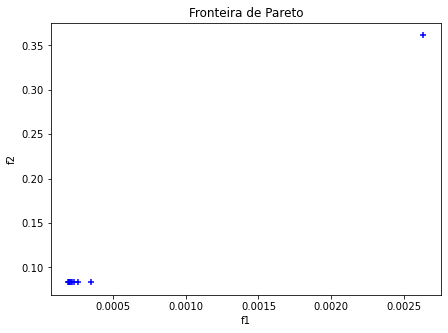

In [8]:
saida1 = metodoPonderacoes(ATIVOS, retATIVOS, covATIVOS)
print('\nMetodo das Ponderação: ')
print(f'Pontos: {len(saida1)}')
metricaDispersao(saida1)
visualizaFronteiras(saida1)

Na Figura 1 há um acumulo de pontos nas áreas de minimização do Lucro (Função Objetivo F1) e Risco (Função Objetivo F2), mas uma menor quantidade de pontos na maximização do Lucro e Risco, isso ocorre pois o Método de Ponderações apresenta limitações na resolução de problemas que não são convexos.

Com o aumento dos pontos na Fronteira de Pareto, Figura 2 e Figura 3, podemos observar a maior dispersão dos pontos na Fronteira que proporciona melhor discretização do problema apresentado na carteira de investimentos. Mesmo com o aumento na dispersão dos pontos, há áreas que não foram localizadas pelo método na Fronteira, reforçando ainda mais a limitação do método anteriormente comentado. 



Metodo das Ponderação: 
Pontos: 101
Dispersao: 0.009873992330725842


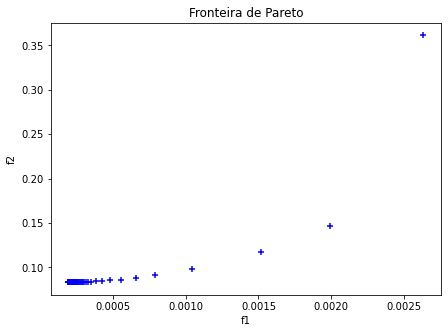

In [9]:
saida1 = metodoPonderacoes(ATIVOS, retATIVOS, covATIVOS, dispersao= 0.01)
print('\nMetodo das Ponderação: ')
print(f'Pontos: {len(saida1)}')
metricaDispersao(saida1)
visualizaFronteiras(saida1)


Metodo das Ponderação: 
Pontos: 1001
Dispersao: 0.016053677910650082


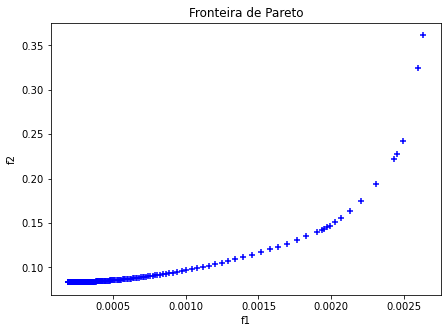

In [10]:
saida1 = metodoPonderacoes(ATIVOS, retATIVOS, covATIVOS, dispersao= 0.001)
print('\nMetodo das Ponderação: ')
print(f'Pontos: {len(saida1)}')
metricaDispersao(saida1)
visualizaFronteiras(saida1)

# Epsilon Restrito

Da mesma forma que aplicamos o Método das Ponderações variando a frequência entre o intervalor de 0 a 1, foram aplicados para o Método Epsilon Restrito, mas variando apenas a frequência para valores entre 0.1 e 0.01. A escolha de não utilizar o terceiro valor para frequência é devido a pequena alteração na dispersão entre os pontos na Fronteira de Pareto, visto que apenas esses dois valores conseguem demostrar o bem esse comportamento na Figura 4 e Figura 5. 

In [11]:
def modelo_metodoEpsilonRestrito(epsilon, ATIVOS, retATIVOS, covATIVOS):
    # Inicializa o problema p que será resolvido com o solver
    p = ConcreteModel()

    # x é uma lista de variáveis de acordo com o número de ativos 
    # NonNegativeReals = valores reais não negativos
    p.Itens = range(ATIVOS)
    p.x = Var(p.Itens, within=NonNegativeReals)

    # declaro as restrições
    p.rest1 = Constraint(expr = sum(p.x[i] for i in p.Itens) == 1)
    # pega a função dois e trasforma em restrição
    p.rest2 = Constraint(expr = sum(covATIVOS[i][j]*p.x[i]*p.x[j] for i in p.Itens for j in p.Itens) <= epsilon )
    # Acrescentar uma restrição, nesse caso 30% do investimento deve corresponder as ações 2, 9, 15, 21 e 35 
    p.rest3 = Constraint(expr = (p.x[1] + p.x[8] + p.x[14] + p.x[20] + p.x[34]) == 0.3)

    # declaro a função-objetivo 1
    p.obj = Objective(expr = sum(retATIVOS[i]*p.x[i] for i in p.Itens), sense=maximize)

    # Resolve
    solver = SolverFactory('ipopt')
    solver.solve(p, tee=False)

    f1 = sum(retATIVOS[i]*p.x[i] for i in p.Itens)
    f2 = sum(covATIVOS[i][j]*p.x[i]*p.x[j] for i in p.Itens for j in p.Itens)

    return [f1(), f2()]   # retorna o ponto

In [12]:
def metodoEpsilonRestrito(ATIVOS, retATIVOS, covATIVOS, dispersao=11):
    [minf1, maxf2] = modelo_metodoPonderacoes(1, 0, ATIVOS, retATIVOS, covATIVOS)
    [maxf1, minf2] = modelo_metodoPonderacoes(0, 1, ATIVOS, retATIVOS, covATIVOS)
    epsilons = np.linspace(minf2, maxf2, dispersao)
    pontosf = []
    for epsilon in epsilons:
        ponto = modelo_metodoEpsilonRestrito(epsilon, ATIVOS, retATIVOS, covATIVOS)
        pontosf.append(ponto)
    return pontosf


Metodo das Epsolon-restrições: 
Pontos: 11
Dispersao: 0.08484295287425074


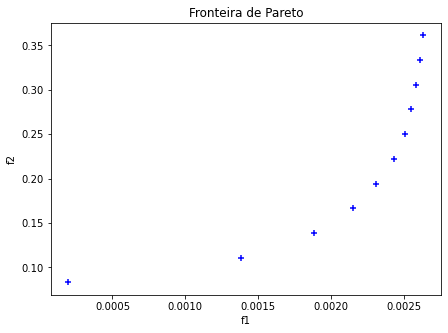

In [13]:
saida2 = metodoEpsilonRestrito(ATIVOS, retATIVOS, covATIVOS)
print('\nMetodo das Epsolon-restrições: ')
print(f'Pontos: {len(saida2)}')
metricaDispersao(saida2)
visualizaFronteiras(saida2)


Metodo das Epsolon-restrições: 
Pontos: 101
Dispersao: 0.08151225732578707


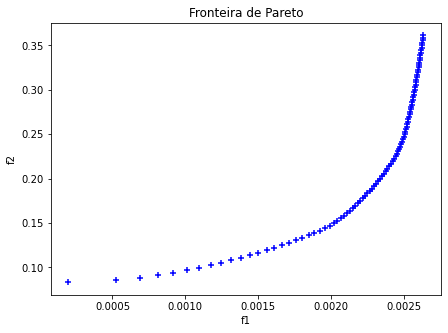

In [14]:
saida2 = metodoEpsilonRestrito(ATIVOS, retATIVOS, covATIVOS, dispersao=101)
print('\nMetodo das Epsolon-restrições: ')
print(f'Pontos: {len(saida2)}')
metricaDispersao(saida2)
visualizaFronteiras(saida2)

Diferente do Método Ponderações, observamos no Método Epsilon Restrito melhor distribuição dos pontos na Fronteira de Pareto, independente da variação da quantidade de pontos utilizados. Além disso, observasse maior acumulo de pontos na discretização na maximização do Lucro e Risco e menor discretização na minimização. Esse comportamento ocorre pois o método apresenta mais facilidade na resolução de problemas que não são convexos.

# Método Critério Global 

In [15]:
def modelo_metodoCriterioGlobal(festrela, ATIVOS, retATIVOS, covATIVOS):
    p = ConcreteModel()

    # x é uma lista de variáveis de acordo com o número de ativos 
    # NonNegativeReals = valores reais não negativos
    p.Itens = range(ATIVOS)
    p.x = Var(p.Itens, within=NonNegativeReals)

    # declaro as restrições
    p.rest1 = Constraint(expr = sum(p.x[i] for i in p.Itens) == 1)
    # Acrescentar uma restrição, nesse caso 30% do investimento deve corresponder as ações 2, 9, 15, 21 e 35 
    p.rest2 = Constraint(expr = (p.x[1] + p.x[8] + p.x[14] + p.x[20] + p.x[34]) == 0.3)

    p.f1 = -(sum(retATIVOS[i]*p.x[i] for i in p.Itens))
    p.f2 = sum(covATIVOS[i][j]*p.x[i]*p.x[j] for i in p.Itens for j in p.Itens)

    # declaro a função-objetivo 1
    p.obj = Objective(expr = sqrt((p.f1-festrela[0])**2 + (p.f2-festrela[1])**2), sense=minimize)

    # Resolve
    solver = SolverFactory('ipopt')
    solver.solve(p, tee=False)

    f1 = sum(retATIVOS[i]*p.x[i] for i in p.Itens)
    f2 = sum(covATIVOS[i][j]*p.x[i]*p.x[j] for i in p.Itens for j in p.Itens)

    return [f1(), f2()]   # retorna o ponto

def metodoCriterioGlobal(ATIVOS, retATIVOS, covATIVOS):
    [minf1, maxf2] = modelo_metodoPonderacoes(1, 0, ATIVOS, retATIVOS, covATIVOS)
    [maxf1, minf2] = modelo_metodoPonderacoes(0, 1, ATIVOS, retATIVOS, covATIVOS)
    festrela = [minf1, minf2]
    ponto = modelo_metodoCriterioGlobal(festrela, ATIVOS, retATIVOS, covATIVOS)
    return ponto, festrela

In [16]:
def main3():
    # leitura e preparação
    ATIVOS, PERIODOS, Preco = leitura("Cotacoes.xlsx") 
    retATIVOS, covATIVOS = preProcessamento(ATIVOS, PERIODOS, Preco)
    saida3, festrela = metodoCriterioGlobal(ATIVOS, retATIVOS, covATIVOS)
    print('\nMetodo das Criterio Global: ')
    print(f'Pontos: {len(saida3)}')
    visualizaFronteiras3(saida3, festrela)

In [17]:
def visualizaFronteiras3(saida3, festrela):
    fig, ax = plt.subplots(figsize=(7,5))  # cria objeto figura e associa eixos
    plt.title("Espaço dos objetivos")
    
    plt.scatter(saida3[0], saida3[1], color='k', marker='o', label = "M. Critério Global")  
    plt.scatter(festrela[0], festrela[1], color='r', marker='*', label = "Solução Utópica")   
                            
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.legend()
    plt.show()


Metodo das Criterio Global: 
Pontos: 2


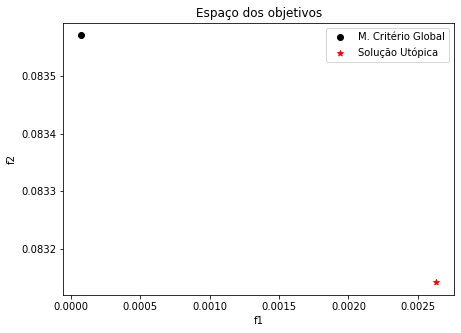

In [18]:
main3()

# Comparação entre os métodos das Ponderações e Epsilon Restrito 

In [19]:
def visualizaFronteiras(saida1, saida2, saida3, festrela):
    fig, ax = plt.subplots(figsize=(10,7))  # cria objeto figura e associa eixos
    plt.title("Espaço dos objetivos")
    
    plt.scatter(saida1[0][0], saida1[0][1], color='b', marker='+', label = "M.Ponderações", s=200)
    for ponto in saida1:
        plt.scatter(ponto[0], ponto[1], color='b', marker='+', s=200)
    
    plt.scatter(saida2[0][0], saida2[0][1], color='g', marker='x', label = "M. E-restrições")   
    for ponto in saida2:
        plt.scatter(ponto[0], ponto[1], color='g', marker='x')
                            
    plt.scatter(saida3[0], saida3[1], color='k', marker='o', label = "M. Critério Global")  
    plt.scatter(festrela[0], festrela[1], color='r', marker='*', label = "Solução Utópica")   
                            
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.legend()
    # ax.set_aspect('equal')
    plt.show()

## Primeira comparação 

A comparação dos métodos permite encontrar qual o melhor método para determinado problema apresentado. Anteriormente foram apresentados separadamente cada método com mudanças na quantidades de pontos na Fronteira de Pareto, mas na Figura 6 e Figura 7 os métodos estão juntos, sendo representado pelo ponto em azul o Ponderações e em verde Epsilon Restrito. Foram acrescentados o Método do Critério Global com o ponto preto e a Solução Utópica em vermelho. 


Metodo das Ponderação: 
Pontos: 11
Dispersao: 0.0003343817756069329

Metodo das Epsolon-restrições: 
Pontos: 11
Dispersao: 0.08484295287425074
11 11


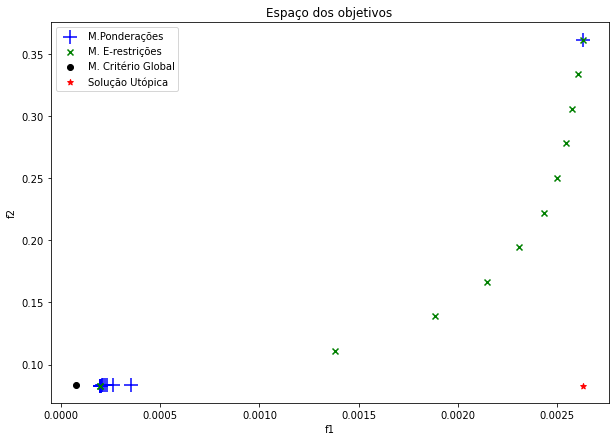

In [20]:
# chamada das demais funções dos métodos implementados
# Ponderacoes
saida1 = metodoPonderacoes(ATIVOS, retATIVOS, covATIVOS)
print('\nMetodo das Ponderação: ')
print(f'Pontos: {len(saida1)}')
metricaDispersao(saida1)
# Epsilon Restricoes
saida2 = metodoEpsilonRestrito(ATIVOS, retATIVOS, covATIVOS)
print('\nMetodo das Epsolon-restrições: ')
print(f'Pontos: {len(saida2)}')
metricaDispersao(saida2)
# Criterio Global
saida3, festrela = metodoCriterioGlobal(ATIVOS, retATIVOS, covATIVOS)

# Gráfico 
print(len(saida1), len(saida2))
visualizaFronteiras(saida1, saida2, saida3, festrela)

Quando falamos de otimização multi-critério, o que queremos é encontrar na Fronteira de Pareto uma grande quantidade de soluções e espalhados de forma homogênea, porque dessa forma podemos oferecer ao decisor um conjunto de possibilidades para tomada de decisão. Esses dois método são classificador como a posteriori,  por justamente encontrar as soluções do processo de otimização do problema e em seguida o decisor atua na escolha da melhor solução desejada.

O método E-Restrito apresentou melhor desempenho na discretização da Fronteira de Pareto comparado ao método da Ponderações, pois com o mesmo número de pontos foram obtidos menores índices de Dispersão entre os pontos na fronteira e menos espaços sem discretização. A melhora no desempenho do método ocorre por não precisar que a Fronteira seja convexa.

O ponto em vermelho apresenta a Solução Utópica e ponto preto representa o a solução do Método do Critério Global. A distância entre esses dois pontos representa a menor distância entre qualquer outro ponto na Fronteira de Pareto.


## Segunda Comparação 


Metodo das Ponderação: 
Pontos: 101
Dispersao: 0.009873992330725842

Metodo das Epsolon-restrições: 
Pontos: 101
Dispersao: 0.08151225732578707
101 101


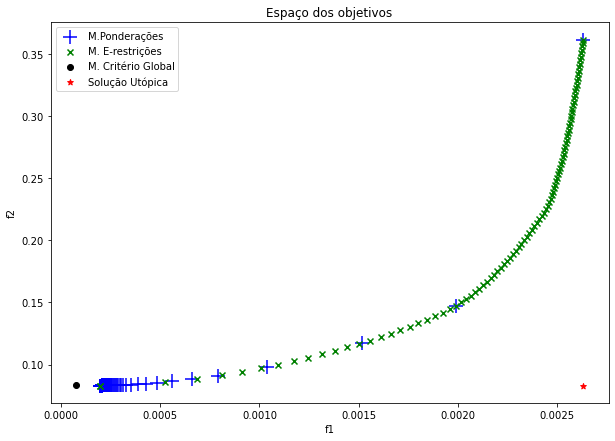

In [21]:
# chamada das demais funções dos métodos implementados
# Ponderacoes
saida1 = metodoPonderacoes(ATIVOS, retATIVOS, covATIVOS, dispersao=0.01)
print('\nMetodo das Ponderação: ')
print(f'Pontos: {len(saida1)}')
metricaDispersao(saida1)
# Epsilon Restricoes
saida2 = metodoEpsilonRestrito(ATIVOS, retATIVOS, covATIVOS, dispersao=101)
print('\nMetodo das Epsolon-restrições: ')
print(f'Pontos: {len(saida2)}')
metricaDispersao(saida2)
# Criterio Global
saida3, festrela = metodoCriterioGlobal(ATIVOS, retATIVOS, covATIVOS)

# Gráfico 
print(len(saida1), len(saida2))
visualizaFronteiras(saida1, saida2, saida3, festrela)

# Goal Programming (Programação por metas)


Outro método aplicado para a carteira de investimentos é a Programação por metas que fornece apenas um resultado na solução do problema. Existem diferentes abordagens para esse método, mas foram aplicados apenas o método clássico e o Lexicographic. 

Com o método clássico podemos observar na Figura 8 os resultados presentes para função objetivo, os valores dos desvios negativos e positivos e qual a fração de investimento dos Ativos na quarta casa decimal (não faz sentido utilizar Ativos com resultados menores) a serem investidos para a solução. A visualização do resultado está na Figura 9.

In [22]:
ATIVOS, PERIODOS, Preco = leitura("Cotacoes.xlsx")
retATIVOS, covATIVOS = preProcessamento(ATIVOS, PERIODOS, Preco)

[minf1, maxf2] = modelo_metodoPonderacoes(1, 0, ATIVOS, retATIVOS, covATIVOS)
[maxf1, minf2] = modelo_metodoPonderacoes(0, 1, ATIVOS, retATIVOS, covATIVOS)

m = ConcreteModel()

# x é uma lista de variáveis de acordo com o número de ativos 
# NonNegativeReals = valores reais não negativos
m.Itens = range(ATIVOS)
m.x = Var(m.Itens, within=NonNegativeReals)

# Desvios negativos do objetivo
m.n1 = Var(within=NonNegativeReals)
m.n2 = Var(within=NonNegativeReals)
# Desvidos positivos do objetivo
m.p1 = Var(within=NonNegativeReals)
m.p2 = Var(within=NonNegativeReals)

# declaro as restrições de acordo com as funções objetivo 
m.rest1 = Constraint(expr = sum(retATIVOS[i]*(-m.x[i]) for i in m.Itens) - m.p1 + m.n1 == maxf1)

m.rest2 = Constraint(expr= sum(covATIVOS[i][j]*m.x[i]*m.x[j] for i in m.Itens for j in m.Itens) - m.p2 + m.n2 == minf2)

# Restrição original do problema
m.rest3 = Constraint(expr = sum(m.x[i] for i in m.Itens) == 1)

# Acrescentar uma restrição, nesse caso 30% do investimento deve corresponder as ações 2, 9, 15, 21 e 35 
m.rest4 = Constraint(expr = (m.x[1] + m.x[8] + m.x[14] + m.x[20] + m.x[34]) == 0.3)

# função objetivo
# F1 maximizar então o desvio indesejável é o n
# F2 minimizar então o desvio indesejável é o p
m.objective = Objective(expr = m.n1 + m.p2, sense=minimize)

solver = SolverFactory('ipopt')
solver.solve(m, tee=False)

f1 = sum(retATIVOS[i]*m.x[i] for i in m.Itens)
f2 = sum(covATIVOS[i][j]*m.x[i]*m.x[j] for i in m.Itens for j in m.Itens)

print("f1 = ", f1())
print("f2 = ", f2())
print()
print("p1 = ", m.p1.value)
print("n1 = ", m.n1.value)
print("p2 = ", m.p2.value)
print("n2 = ", m.n2.value)
print()

if m.n1.value > 0:
    print("O primeiro objetivo é *underachieved* por: ", m.n1.value)
elif m.p1.value > 0:
    print("O primeiro objetivo é *overachieved* por: ", m.p1.value)
else:
    print("O primeiro objetivo é totalmente satisfeito.")

if m.n2.value > 0:
    print("O segundo objetivo é *underachieved* por: ", m.n2.value)
elif m.p2.value > 0:
    print("O segundo objetivo é *overachieved* por: ", m.p2.value)
else:
    print("O segundo objetivo é totalmente satisfeito.")

print()
a = []
for i in m.Itens:
    a.append(m.x[i].value)
    if m.x[i].value > 0.00001:
        print(f"Ativo {i+1}, investimento de {m.x[i].value:.4f}")
print(f'Total de Ativos investidos: {sum(a):.4f}')

f1 =  0.00017916227551447112
f2 =  0.08315000473621051

p1 =  0.0
n1 =  0.0003746097950196621
p2 =  8.14260947537116e-06
n2 =  0.0

O primeiro objetivo é *underachieved* por:  0.0003746097950196621
O segundo objetivo é *overachieved* por:  8.14260947537116e-06

Ativo 7, investimento de 0.1763
Ativo 9, investimento de 0.1074
Ativo 15, investimento de 0.1926
Ativo 34, investimento de 0.1205
Ativo 38, investimento de 0.0619
Ativo 42, investimento de 0.3412
Total de Ativos investidos: 1.0000


In [23]:
def visualizaGoal_P(saida1, saida2, saida3, festrela, maxf1, minf2, resu1, resu2):
    fig, ax = plt.subplots(figsize=(10,7))  # cria objeto figura e associa eixos
    plt.title("Espaço dos objetivos")
    
    plt.scatter(saida1[0][0], saida1[0][1], color='b', marker='+', label = "M.Ponderações", s=200)
    for ponto in saida1:
        plt.scatter(ponto[0], ponto[1], color='b', marker='+', s=200)
    
    plt.scatter(saida2[0][0], saida2[0][1], color='g', marker='x', label = "M. E-restrições")   
    for ponto in saida2:
        plt.scatter(ponto[0], ponto[1], color='g', marker='x')
                            
    plt.scatter(saida3[0], saida3[1], color='k', marker='o', label = "M. Critério Global")  
    plt.scatter(festrela[0], festrela[1], color='r', marker='*', label = "Solução Utópica") 
    
    plt.plot(maxf1, minf2, "bo", markersize=10, label="alvo") 
    plt.plot(resu1,resu2, "ro", markersize=10, label="solução GP1") 
                            
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.legend()
    # ax.set_aspect('equal')
    plt.show()


Metodo das Ponderação: 
Pontos: 11
Dispersao: 0.0003343817756069329

Metodo das Epsolon-restrições: 
Pontos: 11
Dispersao: 0.08484295287425074
11 11


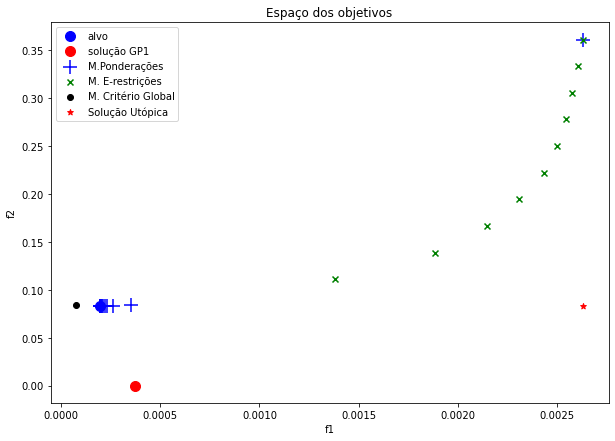

In [24]:
# chamada das demais funções dos métodos implementados
# Ponderacoes
saida1 = metodoPonderacoes(ATIVOS, retATIVOS, covATIVOS)
print('\nMetodo das Ponderação: ')
print(f'Pontos: {len(saida1)}')
metricaDispersao(saida1)
# Epsilon Restricoes
saida2 = metodoEpsilonRestrito(ATIVOS, retATIVOS, covATIVOS)
print('\nMetodo das Epsolon-restrições: ')
print(f'Pontos: {len(saida2)}')
metricaDispersao(saida2)
# Criterio Global
saida3, festrela = metodoCriterioGlobal(ATIVOS, retATIVOS, covATIVOS)

# Gráfico 
print(len(saida1), len(saida2))
visualizaGoal_P(saida1, saida2, saida3, festrela, maxf1, minf2, m.n1.value, m.p1.value)

# Programação por Metas com Priorização (*Lexicographic Goal Programming* – LGP)

Com o Lexicographic podemos observar na Figura 10 os resultados presentes para função objetivo, satisfazendo totalmente Primeira Função de maximização do Lucro,  com a fração de investimento dos Ativos a serem investidos para a solução e a visualização do resultado está na Figura 11.

In [25]:
ATIVOS, PERIODOS, Preco = leitura("Cotacoes.xlsx")
retATIVOS, covATIVOS = preProcessamento(ATIVOS, PERIODOS, Preco)

[minf1, maxf2] = modelo_metodoPonderacoes(1, 0, ATIVOS, retATIVOS, covATIVOS)
[maxf1, minf2] = modelo_metodoPonderacoes(0, 1, ATIVOS, retATIVOS, covATIVOS)

m = ConcreteModel()

# x é uma lista de variáveis de acordo com o número de ativos 
# NonNegativeReals = valores reais não negativos
m.Itens = range(ATIVOS)
m.x = Var(m.Itens, within=NonNegativeReals)

# Desvios negativos do objetivo
m.n1 = Var(within=NonNegativeReals)
m.n2 = Var(within=NonNegativeReals)
# Desvidos positivos do objetivo
m.p1 = Var(within=NonNegativeReals)
m.p2 = Var(within=NonNegativeReals)

# declaro as restrições de acordo com as funções objetivo 
m.rest1 = Constraint(expr = sum(retATIVOS[i]*(-m.x[i]) for i in m.Itens) - m.p1 + m.n1 == maxf1)

m.rest2 = Constraint(expr= sum(covATIVOS[i][j]*m.x[i]*m.x[j] for i in m.Itens for j in m.Itens) - m.p2 + m.n2 == minf2)

# Restrição original do problema
m.rest3 = Constraint(expr = sum(m.x[i] for i in m.Itens) == 1)

# Acrescentar uma restrição, nesse caso 30% do investimento deve corresponder as ações 2, 9, 15, 21 e 35 
m.rest4 = Constraint(expr = (m.x[1] + m.x[8] + m.x[14] + m.x[20] + m.x[34]) == 0.3)

# função objetivo
# F1 maximizar então o desvio indesejável é o n
# F2 minimizar então o desvio indesejável é o p
m.obj_level1 = Objective(expr = m.n1, sense=minimize)
m.obj_level2 = Objective(expr = m.p2, sense=minimize)

# Define a função-objetivo do primeiro nível de priorização
m.obj_level1.activate()
m.obj_level2.deactivate()

# Resolve o problema GP no primeiro nível de priorização 
solver.solve(m)

# Fixa o valor do primeiro nível de priorização 
valor_n1 = m.n1.value  # valor do desvio indesejável para f1

# Define a função-objetivo do segundo nível de priorização
m.obj_level1.deactivate()
m.obj_level2.activate()

# Adiciona uma restrição para o primeiro nível de priorização 
m.rest5 = Constraint(expr = m.n1 == valor_n1)

# Resolve o problema GP no segundo nível de priorização 
solver.solve(m)

f1 = sum(retATIVOS[i]*m.x[i] for i in m.Itens)
f2 = sum(covATIVOS[i][j]*m.x[i]*m.x[j] for i in m.Itens for j in m.Itens)

print("f1 = ", f1())
print("f2 = ", f2())
print()
print("p1 = ", m.p1.value)
print("n1 = ", m.n1.value)
print("p2 = ", m.p2.value)
print("n2 = ", m.n2.value)
print()

if m.n1.value > 0:
    print("O primeiro objetivo é *underachieved* por: ", m.n1.value)
elif m.p1.value > 0:
    print("O primeiro objetivo é *overachieved* por: ", m.p1.value)
else:
    print("O primeiro objetivo é totalmente satisfeito.")

if m.n2.value > 0:
    print("O segundo objetivo é *underachieved* por: ", m.n2.value)
elif m.p2.value > 0:
    print("O segundo objetivo é *overachieved* por: ", m.p2.value)
else:
    print("O segundo objetivo é totalmente satisfeito.")

print('Somatória dos ativos: ', (m.x[i].value for i in m.Itens))

print()
a = []
for i in m.Itens:
    a.append(m.x[i].value)
    if m.x[i].value > 0.00001:
        print(f"Ativo {i+1}, investimento de {m.x[i].value:.4f}")
print(f'Total de Ativos investidos: {sum(a):.4f}')

f1 =  -0.0001954450707874692
f2 =  0.08615406998813367

p1 =  0.0
n1 =  0.0
p2 =  0.0030121882200908573
n2 =  0.0

O primeiro objetivo é totalmente satisfeito.
O segundo objetivo é *overachieved* por:  0.0030121882200908573
Somatória dos ativos:  <generator object <genexpr> at 0x00000248C927D4A0>

Ativo 1, investimento de 0.0028
Ativo 7, investimento de 0.1403
Ativo 9, investimento de 0.1181
Ativo 15, investimento de 0.1819
Ativo 25, investimento de 0.1054
Ativo 34, investimento de 0.0175
Ativo 38, investimento de 0.0875
Ativo 42, investimento de 0.3465
Total de Ativos investidos: 1.0000



Metodo das Ponderação: 
Pontos: 11
Dispersao: 0.0003343817756069329

Metodo das Epsolon-restrições: 
Pontos: 11
Dispersao: 0.08484295287425074
11 11


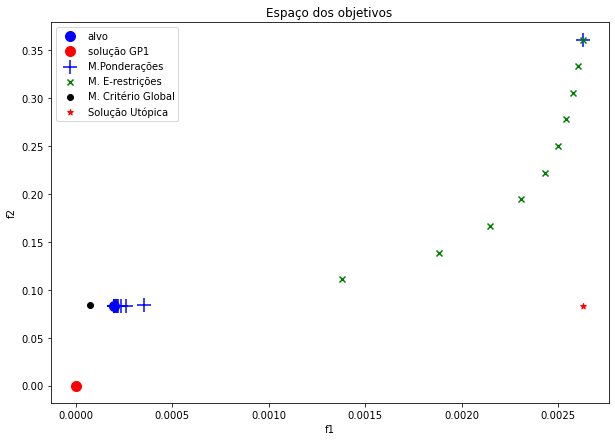

In [26]:
# chamada das demais funções dos métodos implementados
# Ponderacoes
saida1 = metodoPonderacoes(ATIVOS, retATIVOS, covATIVOS)
print('\nMetodo das Ponderação: ')
print(f'Pontos: {len(saida1)}')
metricaDispersao(saida1)
# Epsilon Restricoes
saida2 = metodoEpsilonRestrito(ATIVOS, retATIVOS, covATIVOS)
print('\nMetodo das Epsolon-restrições: ')
print(f'Pontos: {len(saida2)}')
metricaDispersao(saida2)
# Criterio Global
saida3, festrela = metodoCriterioGlobal(ATIVOS, retATIVOS, covATIVOS)

# Gráfico 
print(len(saida1), len(saida2))
visualizaGoal_P(saida1, saida2, saida3, festrela, maxf1, minf2, m.n1.value, m.p1.value)

#  Satisfazendo totalmente Segunda Função de maximização do Lucro

Com o Lexicographic podemos observar na Figura 12 os resultados presentes para função objetivo, satisfazendo totalmente Segunda Função de Minimização do Risco, com a fração de investimento dos Ativos a serem investidos para a solução e a visualização do resultado está na Figura 13.

In [27]:
ATIVOS, PERIODOS, Preco = leitura("Cotacoes.xlsx")
retATIVOS, covATIVOS = preProcessamento(ATIVOS, PERIODOS, Preco)

[minf1, maxf2] = modelo_metodoPonderacoes(1, 0, ATIVOS, retATIVOS, covATIVOS)
[maxf1, minf2] = modelo_metodoPonderacoes(0, 1, ATIVOS, retATIVOS, covATIVOS)

m = ConcreteModel()

# x é uma lista de variáveis de acordo com o número de ativos 
# NonNegativeReals = valores reais não negativos
m.Itens = range(ATIVOS)
m.x = Var(m.Itens, within=NonNegativeReals)

# Desvios negativos do objetivo
m.n1 = Var(within=NonNegativeReals)
m.n2 = Var(within=NonNegativeReals)
# Desvidos positivos do objetivo
m.p1 = Var(within=NonNegativeReals)
m.p2 = Var(within=NonNegativeReals)

# declaro as restrições de acordo com as funções objetivo 
m.rest1 = Constraint(expr = sum(retATIVOS[i]*(-m.x[i]) for i in m.Itens) - m.p1 + m.n1 == maxf1)

m.rest2 = Constraint(expr= sum(covATIVOS[i][j]*m.x[i]*m.x[j] for i in m.Itens for j in m.Itens) - m.p2 + m.n2 == minf2)

# Restrição original do problema
m.rest3 = Constraint(expr = sum(m.x[i] for i in m.Itens) == 1)

# Acrescentar uma restrição, nesse caso 30% do investimento deve corresponder as ações 2, 9, 15, 21 e 35 
m.rest4 = Constraint(expr = (m.x[1] + m.x[8] + m.x[14] + m.x[20] + m.x[34]) == 0.3)

# função objetivo
# F1 maximizar então o desvio indesejável é o n
# F2 minimizar então o desvio indesejável é o p
m.obj_level1 = Objective(expr = m.n1, sense=minimize)
m.obj_level2 = Objective(expr = m.p2, sense=minimize)

# Define a função-objetivo do primeiro nível de priorização
m.obj_level1.deactivate()
m.obj_level2.activate()

# Resolve o problema GP no primeiro nível de priorização 
solver.solve(m)

# Fixa o valor do primeiro nível de priorização 
valor_p2 = m.p2.value  # valor do desvio indesejável para f1

# Define a função-objetivo do segundo nível de priorização
m.obj_level1.activate()
m.obj_level2.deactivate()

# Adiciona uma restrição para o primeiro nível de priorização 
m.rest5 = Constraint(expr = m.p2 == valor_p2)

# Resolve o problema GP no segundo nível de priorização 
solver.solve(m)

f1 = sum(retATIVOS[i]*m.x[i] for i in m.Itens)
f2 = sum(covATIVOS[i][j]*m.x[i]*m.x[j] for i in m.Itens for j in m.Itens)

print("f1 = ", f1())
print("f2 = ", f2())
print()
print("p1 = ", m.p1.value)
print("n1 = ", m.n1.value)
print("p2 = ", m.p2.value)
print("n2 = ", m.n2.value)
print()

if m.n1.value > 0:
    print("O primeiro objetivo é *underachieved* por: ", m.n1.value)
elif m.p1.value > 0:
    print("O primeiro objetivo é *overachieved* por: ", m.p1.value)
else:
    print("O primeiro objetivo é totalmente satisfeito.")

if m.n2.value > 0:
    print("O segundo objetivo é *underachieved* por: ", m.n2.value)
elif m.p2.value > 0:
    print("O segundo objetivo é *overachieved* por: ", m.p2.value)
else:
    print("O segundo objetivo é totalmente satisfeito.")

print()
a = []
for i in m.Itens:
    a.append(m.x[i].value)
    if m.x[i].value > 0.00001:
        print(f"Ativo {i+1}, investimento de {m.x[i].value:.4f}")
print(f'Total de Ativos investidos: {sum(a):.4f}')

f1 =  0.00019353591786927944
f2 =  0.08314195204355741

p1 =  0.0
n1 =  0.00038898195700626026
p2 =  0.0
n2 =  0.0

O primeiro objetivo é *underachieved* por:  0.00038898195700626026
O segundo objetivo é totalmente satisfeito.

Ativo 7, investimento de 0.1743
Ativo 9, investimento de 0.1073
Ativo 15, investimento de 0.1927
Ativo 34, investimento de 0.1275
Ativo 38, investimento de 0.0591
Ativo 42, investimento de 0.3392
Total de Ativos investidos: 1.0000



Metodo das Ponderação: 
Pontos: 11
Dispersao: 0.0003343817756069329

Metodo das Epsolon-restrições: 
Pontos: 11
Dispersao: 0.08484295287425074
11 11


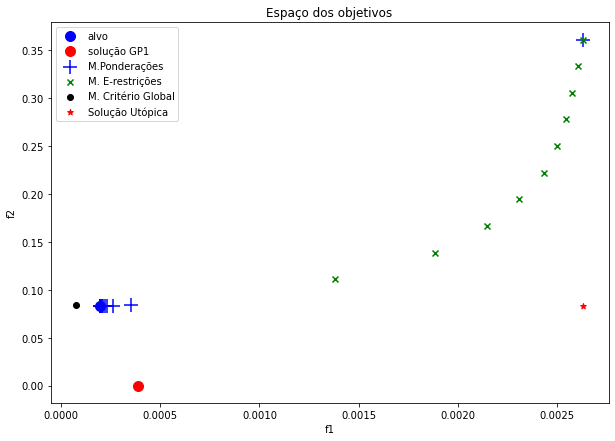

In [28]:
# chamada das demais funções dos métodos implementados
# Ponderacoes
saida1 = metodoPonderacoes(ATIVOS, retATIVOS, covATIVOS)
print('\nMetodo das Ponderação: ')
print(f'Pontos: {len(saida1)}')
metricaDispersao(saida1)
# Epsilon Restricoes
saida2 = metodoEpsilonRestrito(ATIVOS, retATIVOS, covATIVOS)
print('\nMetodo das Epsolon-restrições: ')
print(f'Pontos: {len(saida2)}')
metricaDispersao(saida2)
# Criterio Global
saida3, festrela = metodoCriterioGlobal(ATIVOS, retATIVOS, covATIVOS)

# Gráfico 
print(len(saida1), len(saida2))
visualizaGoal_P(saida1, saida2, saida3, festrela, maxf1, minf2, m.n1.value, m.p1.value)

Utilizando o método Goal Programming com abordagem Lexicographic encontramos os valores para cada função objetivo com diferentes tipos de prioridade, seja na maximização do lucro ou na minimização do risco. Esse método é classificado com a priori, ou seja, diferente dos dois métodos aplicados anteriormente em que o decisor recebe uma grande quantidade de soluções para posteriormente decidir qual Ativo investir, o método Goal Programming fornece apenas uma solução para o decisor. 